In [1]:
import numpy as np
from brian2 import *
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
import numpy as np
from brian2 import *
import matplotlib.pyplot as plt

def pyramidal_model(N, I_s_ext_amp, I_d_ext, sig_ou_s, sig_ou_d, tau_stdp,
                   rate_ampa_s, rate_gaba_s, rate_ampa_d, rate_gaba_d, mu_s = 0, mu_d = 0):
    # Differential equations for the somatic compartment
    soma_eqs = '''
    du_s/dt = - (u_s - EL)/tau_s + (g_s * m + I_s + w_s) / C_s : volt (unless refractory)
    dw_s/dt = - w_s / tau_w_s : amp
    
    I_s = I_s_ext + I_ampa_s + I_gaba_s + I_s_bg : amp
    I_s_ext = I_s_ext_pulse * int((t > 100*ms) and (t < 600*ms)) : amp 
    I_ampa_s = g_ampa_s * (V_ampa - u_s) : amp
    I_gaba_s = g_gaba_s * (V_gaba - u_s) : amp
    dI_s_bg/dt = (mu_s - I_s_bg) / tau_ou_s + sig_ou_s * xi_s/sqrt(tau_ou_s/2) : amp
    dg_ampa_s/dt = -g_ampa_s/tau_ampa : siemens
    dg_gaba_s/dt = -g_gaba_s/tau_gaba : siemens
    
    start_trace_burst : 1 (linked) 
    stop_trace_burst : 1 (linked) 
    u_d : volt (linked)
    m : 1 (linked)
    '''

    # Differential equations for the dendritic compartment
    dend_eqs = '''
    du_d/dt = - (u_d - EL)/tau_d + (g_d * m + K + I_d + w_d) / C_d : volt
    dw_d/dt = (- w_d + a_w_d * (u_d - EL)) / tau_w_d : amp
    
    I_d = I_d_ext + I_ampa_d + I_gaba_d + I_d_bg : amp
    I_ampa_d = g_ampa_d * (V_ampa - u_d) : amp
    I_gaba_d = g_gaba_d * (V_gaba - u_d) : amp
    dI_d_bg/dt = (mu_d - I_d_bg) / tau_ou_d + sig_ou_d * xi_d/sqrt(tau_ou_d/2) : amp
    dg_ampa_d/dt = -g_ampa_d/tau_ampa : siemens
    dg_gaba_d/dt = -g_gaba_d/tau_gaba : siemens
    
    dstart_trace_burst/dt = -start_trace_burst/tau_burst : 1
    dstop_trace_burst/dt = -stop_trace_burst/tau_burst : 1

    m = 1/(1 + exp(-(u_d - Ed) / Dm)) : 1
    Ca_spike = 1/(1 + exp(-(u_d - Ed2) / Dm2)) : 1
    
    lastspike_soma : second (linked)
    K_active = int((t-lastspike_soma) > K1) * int((t-lastspike_soma) < K2) : 1
    K = K_active * c_d : amp
    dburst_trace/dt = -burst_trace/tau_stdp : 1
    '''

    # Parameters for somatic compartment
    params_soma = {
        'tau_s': 16.0 * ms,
        'C_s': 370.0 * pF,
        'g_s': 1300.0 * pA,
        'b_w_s': -200 * pA,
        'tau_w_s': 100.0 * ms,
        'EL': -70 * mV,
        'Ed': -38 * mV,
        'Dm': 6 * mV,
        'mu_s': mu_s * pA,
        'tau_ou_s': 2.0 * ms,
        'tau_gaba': 10 * ms,
        'tau_ampa': 5 * ms,
        'I_s_ext_pulse': I_s_ext_amp * pA,
        'sig_ou_s': sig_ou_s * pA,
        'V_ampa': 0 * mV,
        'V_gaba': -80 * mV,
        'g_ampa_s_unit': 0.2* 1 * (370.0 * pF / (16.0 * ms)),
        'g_gaba_s_unit': 0.6* 1 * (370.0 * pF / (16.0 * ms)),
    }
    
    # Define somatic compartment
    soma = NeuronGroup(N, model=soma_eqs, threshold='u_s > -50 * mV',
                        reset='w_s += b_w_s\nu_s = EL\nstart_trace_burst += 1\nstop_trace_burst = 1',
                        refractory=3 * ms, namespace=params_soma, method='euler', dt=0.1 * ms)

    soma.u_s = 'EL + rand() * 10 * mV'

    # Parameters for dendritic compartment
    params_dend = {
        'tau_d': 7.0 * ms,
        'C_d': 170.0 * pF,
        'g_d': 1200.0 * pA,
        'c_d': 2600.0 * pA,
        'tau_w_d': 30.0 * ms,
        'a_w_d': -13 * nS,
        'EL': -70 * mV,
        'Ed': -38 * mV,
        'Dm': 6 * mV,
        'Ed2': -20 * mV,
        'Dm2': 0.01 * mV,
        'K1': 0.499 * ms,
        'K2': 2.501 * ms,
        'tau_burst': -16 / np.log(0.1) * ms,
        'mu_d': mu_d * pA,
        'tau_ou_d': 2.0 * ms,
        'tau_gaba': 10 * ms,
        'tau_ampa': 5 * ms,
        'I_d_ext': I_d_ext * pA,
        'sig_ou_d': sig_ou_d * pA,
        'tau_stdp': tau_stdp,
        'V_ampa': 0 * mV,
        'V_gaba': -80 * mV,
        'g_ampa_d_unit': 0.2  * 8 * (170.0 * pF / (7.0 * ms)),
        'g_gaba_d_unit': 0.4  * 8 * (170.0 * pF / (7.0 * ms)),
    }

    # Define dendritic compartment
    dend = NeuronGroup(N, model=dend_eqs, threshold='start_trace_burst > 1.1',
                        reset='burst_trace += 1\nstart_trace_burst = 0',
                        refractory='stop_trace_burst > 0.1', namespace=params_dend, method='euler', dt=0.1 * ms)

    dend.u_d = 'EL + rand() * 10 * mV'

    # Link variables between soma and dendrite
    soma.u_d = linked_var(dend, 'u_d')
    soma.m = linked_var(dend, 'm')
    dend.lastspike_soma = linked_var(soma, 'lastspike')
    soma.start_trace_burst = linked_var(dend, 'start_trace_burst')
    soma.stop_trace_burst = linked_var(dend, 'stop_trace_burst')

    # Poisson inputs for synaptic conductances
    poisson_ampa_s = PoissonGroup(N, rates=rate_ampa_s * Hz)
    poisson_gaba_s = PoissonGroup(N, rates=rate_gaba_s * Hz)
    poisson_ampa_d = PoissonGroup(N, rates=rate_ampa_d * Hz)
    poisson_gaba_d = PoissonGroup(N, rates=rate_gaba_d * Hz)

    # Synaptic connections
    syn_ampa_s = Synapses(poisson_ampa_s, soma, model='w : siemens', on_pre='g_ampa_s += w')
    syn_gaba_s = Synapses(poisson_gaba_s, soma, model='w : siemens', on_pre='g_gaba_s += w')
    syn_ampa_d = Synapses(poisson_ampa_d, dend, model='w : siemens', on_pre='g_ampa_d += w')
    syn_gaba_d = Synapses(poisson_gaba_d, dend, model='w : siemens', on_pre='g_gaba_d += w')

    syn_ampa_s.connect(j='i')
    syn_gaba_s.connect(j='i')
    syn_ampa_d.connect(j='i')
    syn_gaba_d.connect(j='i')

    syn_ampa_s.w = params_soma['g_ampa_s_unit']
    syn_gaba_s.w = params_soma['g_gaba_s_unit']
    syn_ampa_d.w = params_dend['g_ampa_d_unit']
    syn_gaba_d.w = params_dend['g_gaba_d_unit']

    ### ANALYSIS RESTORED: Monitors ###
    var_soma = StateMonitor(soma, 'u_s', record=[0])
    var_dend = StateMonitor(dend, 'u_d', record=[0])
    spike_soma = SpikeMonitor(soma)
    i_s_bg_monitor = StateMonitor(soma, 'I_s_bg', record=[0])
    i_d_bg_monitor = StateMonitor(dend, 'I_d_bg', record=[0])
    i_s_ext_monitor = StateMonitor(soma, 'I_s_ext', record=[0])
    calcium_monitor = StateMonitor(dend, 'Ca_spike', record=[0])

    # --- ADDED MONITORS ---
    soma_syn_monitor = StateMonitor(soma, ['g_ampa_s', 'g_gaba_s', 'I_ampa_s', 'I_gaba_s'], record=[0])
    dend_syn_monitor = StateMonitor(dend, ['g_ampa_d', 'g_gaba_d', 'I_ampa_d', 'I_gaba_d'], record=[0])
    # ----------------------

    sp_pre_ampa_s = SpikeMonitor(poisson_ampa_s)
    sp_pre_gaba_s = SpikeMonitor(poisson_gaba_s)
    sp_pre_ampa_d = SpikeMonitor(poisson_ampa_d)
    sp_pre_gaba_d = SpikeMonitor(poisson_gaba_d)
    # ----------------------------------

    # Run simulation for 700ms
    run(700 * ms, report='stdout', profile=True)

    ### ANALYSIS RESTORED: Spike Classification ###
    isi_threshold = 14 * ms
    s_times = spike_soma.spike_trains()[0]
    ca_times = calcium_monitor.t
    ca_trace = calcium_monitor.Ca_spike[0]

    simple_spike_times = []
    burst_spike_times = []
    putative_spike_times = []

    if len(s_times) > 0:
        total_spikes = len(s_times)
        if total_spikes == 1:
            simple_spike_times.append(s_times[0])
        else:
            current_burst_start_idx = 0
            in_burst = False
            for j in range(total_spikes - 1):
                isi = s_times[j+1] - s_times[j]
                if isi < isi_threshold:
                    if not in_burst:
                        in_burst = True
                        current_burst_start_idx = j
                else:
                    if in_burst:
                        burst_start_time = s_times[current_burst_start_idx]
                        burst_end_time = s_times[j]
                        start_idx = np.searchsorted(ca_times, burst_start_time, side='left')
                        end_idx = np.searchsorted(ca_times, burst_end_time, side='right')
                        group_spikes = s_times[current_burst_start_idx:j+1]
                        if np.any(ca_trace[start_idx:end_idx] == 1):
                            burst_spike_times.extend(group_spikes)
                        else:
                            putative_spike_times.extend(group_spikes)
                        in_burst = False
                    else:
                        simple_spike_times.append(s_times[j])
            # handle last spike/burst
            if in_burst:
                j = total_spikes - 1
                burst_start_time = s_times[current_burst_start_idx]
                burst_end_time = s_times[j]
                start_idx = np.searchsorted(ca_times, burst_start_time, side='left')
                end_idx = np.searchsorted(ca_times, burst_end_time, side='right')
                group_spikes = s_times[current_burst_start_idx:j+1]
                if np.any(ca_trace[start_idx:end_idx] == 1):
                    burst_spike_times.extend(group_spikes)
                else:
                    putative_spike_times.extend(group_spikes)
            else:
                simple_spike_times.append(s_times[-1])

    # --- UPDATED RETURN STATEMENT ---
    return (var_soma, var_dend, spike_soma, simple_spike_times, burst_spike_times, putative_spike_times, calcium_monitor,
            i_s_ext_monitor, i_s_bg_monitor, i_d_bg_monitor,
            soma_syn_monitor, dend_syn_monitor,
            sp_pre_ampa_s, sp_pre_gaba_s, sp_pre_ampa_d, sp_pre_gaba_d)
    # ------------------------------




In [3]:
rate_s = 100
rate_d = 100
I_s_ext_amp = 500
# set seed for reproducibility
seed(28)
# Run the model with some example parameters
(var_soma, var_dend, spike_soma, simple_spike_times, burst_spike_times, putative_spike_times, calcium_monitor,
 i_s_ext_monitor, i_s_bg_monitor, i_d_bg_monitor,
 soma_syn_monitor, dend_syn_monitor,
 sp_pre_ampa_s, sp_pre_gaba_s, sp_pre_ampa_d, sp_pre_gaba_d) = pyramidal_model(
    N=5, I_s_ext_amp=I_s_ext_amp, I_d_ext=0, sig_ou_s=0, sig_ou_d=0,
    tau_stdp=20*ms, rate_ampa_s=rate_s, rate_gaba_s=rate_s,
    rate_ampa_d=rate_d, rate_gaba_d=rate_d
)

WARNING    The name "mu_s" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup". Will use the object from the group-specific namespace with the value 0. * amp, but the name also refers to a variable in the run namespace with value '0'. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    The name "sig_ou_s" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup". Will use the object from the group-specific namespace with the value 0. * amp, but the name also refers to a variable in the run namespace with value '0'. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    The name "mu_d" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_1". Will use the object from the group-specific namespace with the value 0. * amp, but the name also refers to a variable in the run namespace with

Starting simulation at t=0. s for a duration of 0.7 s
0.7 s (100%) simulated in < 1s


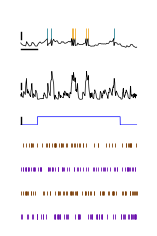

In [4]:
# For this plot, we only need the spike times from the monitor.
cell_id = 0
inh_color = '#6A0DAD'
ext_color = '#7A3B03'
# --- 2. Create the new, detailed plot ---
# Define figure size in inches
width = 40 / 25.4 
height = 60 / 25.4 

# Create 7 subplots for the detailed view
fig, axs = plt.subplots(7, 1, figsize=(width, height), sharex=True,
                        gridspec_kw={'height_ratios': [4, 4, 1, 1, 1, 1, 1]})

# Plot 1: Soma Voltage with Spike Classification
axs[0].plot(var_soma.t / ms, var_soma.u_s[cell_id] / mV, color='k', label='Soma $V_m$', linewidth=0.5)
axs[0].vlines([t / ms for t in simple_spike_times], ymin=-50, ymax=-20, color='#026C80', lw=0.5, label='Simple Spikes')
axs[0].vlines([t / ms for t in burst_spike_times], ymin=-50, ymax=-20, color='#EE9B00', lw=0.5, label='Burst Spikes')
axs[0].vlines([t / ms for t in putative_spike_times], ymin=-50, ymax=-20, color='green', lw=0.5, label='Putative Spikes')


# --- Plot 2: Dendrite Voltage ---
axs[1].plot(var_dend.t / ms, var_dend.u_d[cell_id] / mV, lw=0.5, color='k')
#axs[1].set_ylabel('Dendrite V (mV)', fontsize=8)

# Sync Y-axis for voltage plots
ylim_min = -85
ylim_max = 20
axs[0].set_ylim(ylim_min, ylim_max)
axs[1].set_ylim(ylim_min, ylim_max)

# --- Plot 3: External Input Current ---
axs[2].plot(i_s_ext_monitor.t / ms, i_s_ext_monitor.I_s_ext[cell_id] / pA, color='b', lw=0.5)
#axs[2].set_ylabel('$I_{ext}$ (pA)', fontsize=8)

# # --- Plot 4: Somatic Synaptic Conductances ---
# axs[3].plot(soma_syn_monitor.t / ms, soma_syn_monitor.g_ampa_s[cell_id] / nS, color=ext_color, lw=0.5, label='AMPA')
# axs[4].plot(soma_syn_monitor.t / ms, soma_syn_monitor.g_gaba_s[cell_id] / nS, color=inh_color, lw=0.5, label='GABA')
# # axs[3] and axs[4] share the same y-axis
# ylim_max_g = max(np.max(soma_syn_monitor.g_ampa_s[cell_id] / nS), np.max(soma_syn_monitor.g_gaba_s[cell_id] / nS))
# # axs[3].set_ylim(0, ylim_max_g * 1.1)
# # axs[4].set_ylim(0, ylim_max_g * 1.1)
# #axs[3].set_ylabel('Soma g (nS)', fontsize=8)
# #axs[3].legend(loc='upper right', fontsize='x-small', frameon=False)

# # --- Plot 6: Dendritic Synaptic Conductances ---
# axs[5].plot(dend_syn_monitor.t / ms, dend_syn_monitor.g_ampa_d[cell_id] / nS, color=ext_color, lw=0.5)
# axs[6].plot(dend_syn_monitor.t / ms, dend_syn_monitor.g_gaba_d[cell_id] / nS, color=inh_color, lw=0.5)
# #axs[5].set_ylabel('Dendrite g (nS)', fontsize=8)

# # axs[3] and axs[4] share the same y-axis
# ylim_max_g = max(np.max(dend_syn_monitor.g_ampa_d[cell_id] / nS), np.max(dend_syn_monitor.g_gaba_d[cell_id] / nS))
# # axs[5].set_ylim(0, ylim_max_g * 1.1)
# # axs[6].set_ylim(0, ylim_max_g * 1.1)

# # --- Plot 5: Somatic Synaptic Currents ---
# # axs[5].plot(soma_syn_monitor.t / ms, soma_syn_monitor.I_ampa_s[0] / pA, color='green', lw=0.5)
# # axs[5].plot(soma_syn_monitor.t / ms, soma_syn_monitor.I_gaba_s[0] / pA, color='blue', lw=0.5)
# # #axs[4].set_ylabel('Soma I (pA)', fontsize=8)


# # # --- Plot 7: Dendritic Synaptic Currents ---
# # axs[6].plot(dend_syn_monitor.t / ms, dend_syn_monitor.I_ampa_d[0] / pA, color='green', lw=0.5)
# # axs[6].plot(dend_syn_monitor.t / ms, dend_syn_monitor.I_gaba_d[0] / pA, color='blue', lw=0.5)
# #axs[6].set_ylabel('Dendrite I (pA)', fontsize=8)

def raster_single(ax, spmon, cell_id, color):
    t = spmon.t[spmon.i == cell_id] / ms
    ax.eventplot([t], linewidths=0.6, color=color)

raster_single(axs[3], sp_pre_ampa_s, cell_id, ext_color)
raster_single(axs[4], sp_pre_gaba_s, cell_id, inh_color)
raster_single(axs[5], sp_pre_ampa_d, cell_id, ext_color)
raster_single(axs[6], sp_pre_gaba_d, cell_id, inh_color)

# add vertical scale bar to axs[0]
axs[0].add_artist(plt.Line2D([1.02, 1.02], [-50, -30], color='k', lw=1.))
axs[1].add_artist(plt.Line2D([1.02, 1.02], [-50, -30], color='k', lw=1.))

axs[2].add_artist(plt.Line2D([1.02, 1.02], [0, 500], color='k', lw=1.))

axs[0].add_artist(plt.Line2D([0, 100], [-80, -80], color='k', lw=1.))

axs[0].set_ylim(-85, 20)
axs[1].set_ylim(-85, 20)

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

fig.savefig('illustration_synaptic_input.pdf', bbox_inches='tight', dpi=300)